This notebook does two things: 1) tracks the co-firing of cells as it increases/decreases on each day, and 2) tests whether day 4 (learning-related) increases in syncrony persist with the same cell pairs between controls and ANI mice.

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err
import covariance_analysis as cova

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'
save_dir = '/Users/nkinsky/Documents/BU/Working/Eraser'

In [2]:
# Helper functions to block printing output
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


In [113]:
from copy import deepcopy

def add_memory_designations(df_use):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
    during_ind = np.where(df["d1_d2"] == "4_1")[0]
    after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            print('Before')
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"
    df.insert(1, "Designation", desig)
    
    return df

In [21]:
def stats_before_after(df_use, key_use):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups."""
    
    df_after = df_use[np.bitwise_or(df_use['d1_d2'] == '1_2', df_use['d1_d2'] == '2_7')]
    df_before = df_use[np.bitwise_or(df_use['d1_d2'] == '-2_-1', df_use['d1_d2'] == '-1_4')]
    df4 = df_use[df_use['d1_d2'] == '4_1']
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use])
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use])
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    print(f'p={p_bef:0.3g} baseline b/w groups')
    print(f'p={p_aft:0.3g} day 1-2 b/w groups')
    print(f'p={p_ctrl:0.3g} before-after Ctrl')
    print(f'p={p_ani:0.3g} before-after ANI')

Step 0: Set up all dicts for plotting.

In [13]:
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True)

Marble07: 6it [00:04,  1.34it/s]
Marble12: 6it [00:03,  1.59it/s]
Marble24: 6it [00:03,  1.51it/s]
Marble27: 6it [00:04,  1.45it/s]
Marble06: 6it [00:06,  1.01s/it]
Marble11: 6it [00:05,  1.04it/s]
Marble29: 6it [00:04,  1.46it/s]
Marble17: 6it [00:04,  1.24it/s]
Marble18: 6it [00:03,  1.61it/s]
Marble19: 6it [00:04,  1.44it/s]
Marble20: 6it [00:03,  1.61it/s]
Marble25: 6it [00:04,  1.38it/s]
Marble07: 6it [00:05,  1.00it/s]
Marble12: 6it [00:05,  1.15it/s]
Marble24: 6it [00:05,  1.14it/s]
Marble27: 6it [00:05,  1.11it/s]
Marble06: 6it [00:07,  1.20s/it]
Marble11: 6it [00:07,  1.25s/it]
Marble29: 6it [00:05,  1.06it/s]
Marble17: 6it [00:06,  1.07s/it]
Marble18: 6it [00:05,  1.18it/s]
Marble19: 6it [00:05,  1.06it/s]
Marble20: 6it [00:05,  1.15it/s]
Marble25: 6it [00:05,  1.05it/s]


Plot #1: Freeze cell covariance before (day -1 and -2), 4 hr, and after (day 1 and 2), all normalized to day -2.  

In [114]:
sigz_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

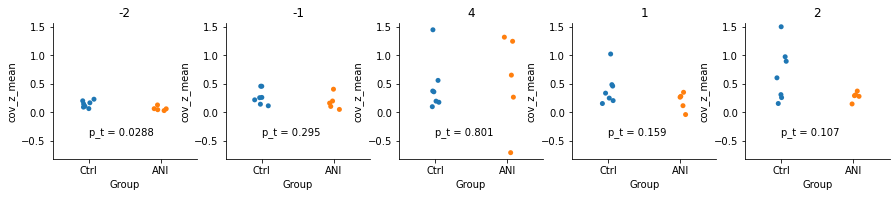

In [115]:
sigz_df = sigz_freeze_df

pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['cov_z_mean'])
    
    a.text(0, -0.4, f'p_t = {pval:.3g}')
    
erp.match_max_lims(ax, axis='y')
stats_before_after(sigz_df, 'cov_z_mean')

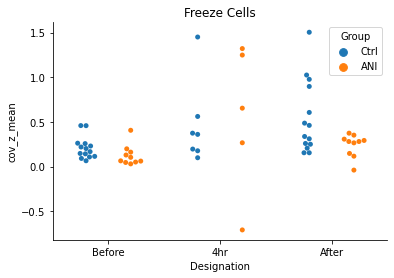

In [116]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=sigz_freeze_df, dodge=True, ax=ax)
ax.set_title('Freeze Cells')
sns.despine(ax=ax)

Plot #2: Same as #1 but for all cells

In [104]:
allz_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True)
allz_df = add_memory_designations(allz_df)

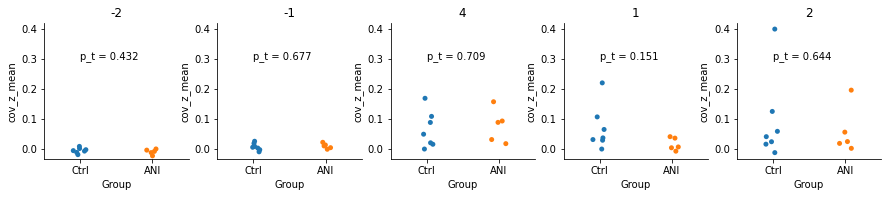

In [105]:
sigz_df = allz_df

pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['cov_z_mean'])
    
    a.text(0, 0.3, f'p_t = {pval:.3g}')
    
erp.match_max_lims(ax, axis='y')
stats_before_after(sigz_df, 'cov_z_mean')

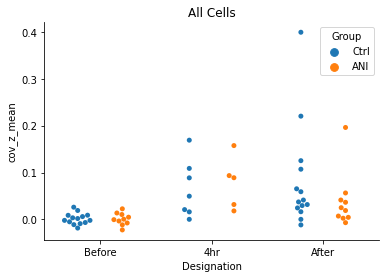

In [117]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=allz_df, dodge=True, ax=ax)
ax.set_title('All Cells')
sns.despine(ax=ax)

Plot #3: Same as #1 and #2 but for all cells on 4 hr session which have covariance > 2std above mean.  This one might be messy due to lots of cell turnover in ANI mice.

Plot #4: ID freeze cells on 4 hr session and track covariance forward/backward across whole experiment.  Include silent cells in code, but plot two ways: 1) turnover in freeze cell population between sessions, and 2) change in covariance from 4 hr session forward/backward in time.  

Plot #5: Same as #4 but do control plot (ID cells on day -1) and plot of consolidated cells (ID cells on day 1).